<a href="https://colab.research.google.com/github/zahrafali/PatternRecognition/blob/main/PR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from simDiagonalization import simultaneousDiagonalization 
from mleMeanCov import mleMean, mleCov
from plotting import plot_2d_graph
df1 = pd.read_csv('heart.csv')
df1

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [4]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df1, test_size=0.5, random_state=25)

x1 = training_data[training_data['target'] == 0]
cp_1 = x1['cp']
thalach_1 = x1['thalach']#/100
slope_1 = x1['slope']
restecg_1 = x1['restecg']
fbs_1 = x1['fbs']
chol_1 = x1['chol']#/100
x1_matrix_raw = [list(cp_1), list(thalach_1), list(slope_1), list(restecg_1), list(fbs_1), list(chol_1)]

x2 = training_data[training_data['target'] > 0]
cp_2 = x2['cp']
thalach_2 = x2['thalach']
slope_2 = x2['slope']
restecg_2 = x2['restecg']
fbs_2 = x2['fbs']
chol_2 = x2['chol']
x2_matrix_raw = [list(cp_2), list(thalach_2), list(slope_2), list(restecg_2), list(fbs_2), list(chol_2)]
thalach_1

72     144
797    114
175    133
589    116
393    145
      ... 
940    123
151    195
886    140
474    168
318    162
Name: thalach, Length: 244, dtype: int64

In [5]:
# Normalizing range 0 to 1
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
# x1_matrix = min_max_scaler.fit_transform(x1_matrix_raw)
# x2_matrix = min_max_scaler.fit_transform(x2_matrix_raw)
x1_matrix = x1_matrix_raw
x2_matrix = x2_matrix_raw

In [7]:
#@title CALCULATING ML MEAN AND COVARIANCE
x1_no_of_points = len(x1_matrix[0])
# get estimated mean and covariance using ML method
x1_ml_estimated_mean = mleMean(x1_matrix, x1_no_of_points)
# x1_ml_estimated_cov = estimate_cov_ml(x1_training_points, x1_ml_estimated_mean, no_of_points)
print('\nEstimated Mean1 using ML before Diagonalization:')
print(x1_ml_estimated_mean)
x1_ml_estimated_cov = mleCov(x1_matrix, x1_ml_estimated_mean, x1_no_of_points)
print('\nEstimated covariance1 using ML before Diagonalization:')
print(x1_ml_estimated_cov)
x2_no_of_points = len(x2_matrix[0])
x2_ml_estimated_mean = mleMean(x2_matrix, x2_no_of_points)
x2_ml_estimated_cov = mleCov(x2_matrix, x2_ml_estimated_mean, x2_no_of_points)
print('\nEstimated Mean2 using ML before Diagonalization:')
print(x2_ml_estimated_mean)
print('\nEstimated covariance2 using ML before Diagonalization:')
print(x2_ml_estimated_cov)


Estimated Mean1 using ML before Diagonalization:
[[4.87704918e-01]
 [1.39553279e+02]
 [1.13114754e+00]
 [4.71311475e-01]
 [1.47540984e-01]
 [2.50467213e+02]]

Estimated covariance1 using ML before Diagonalization:
[[ 8.64602929e-01  4.64819605e+00  3.84977157e-02  3.74563289e-03
  -6.38269282e-03  6.61482128e-01]
 [ 4.64819605e+00  5.39870112e+02  5.61596345e+00 -5.88635447e-01
  -1.60575114e-02  5.15119927e+01]
 [ 3.84977157e-02  5.61596345e+00  3.18865896e-01 -3.35931201e-04
  -3.98414405e-02 -9.01437786e-01]
 [ 3.74563289e-03 -5.88635447e-01 -3.35931201e-04  2.98357296e-01
  -1.21607095e-02 -4.62184225e+00]
 [-6.38269282e-03 -1.60575114e-02 -3.98414405e-02 -1.21607095e-02
   1.25772642e-01  5.70411180e-01]
 [ 6.61482128e-01  5.15119927e+01 -9.01437786e-01 -4.62184225e+00
   5.70411180e-01  2.39187188e+03]]

Estimated Mean2 using ML before Diagonalization:
[[1.38432836e+00]
 [1.57850746e+02]
 [1.56716418e+00]
 [6.11940299e-01]
 [1.41791045e-01]
 [2.38981343e+02]]

Estimated covarian

In [14]:
#@title Plotting
########################################################################################
# PLOTTING #
import matplotlib.pyplot as plt
import numpy as np
import math
from prettytable import PrettyTable

def plot_2d_graph(w1_matrix, w2_matrix, x1, x2, x1_label, x2_label, title):
    plt.plot(w1_matrix[x1 - 1], w1_matrix[x2 - 1], 'r.', label="Class 1")
    plt.plot(w2_matrix[x1 - 1], w2_matrix[x2 - 1], 'b.', label="Class 2")
    # plt.plot(w1_matrix[1], w1_matrix[5], 'r.', label="Class 1")
    # plt.plot(w2_matrix[1], w2_matrix[5], 'b.', label="Class 2")
    plt.xlabel(x1_label)
    plt.ylabel(x2_label)
    # max_w_1 = max(w1_matrix[x1 - 1])
    # min_w_1 = min(w1_matrix[x1 - 1])
    # max_w_2 = max(w2_matrix[x2 - 1])
    # min_w_2 = min(w2_matrix[x2 - 1])
    max_w = max(max(max(w1_matrix[x1-1]), max(w2_matrix[x2-1])),
                max(max(w1_matrix[x1-1]), max(w2_matrix[x2-1])))
    min_w = min(min(min(w1_matrix[x1-1]), min(w2_matrix[x2-1])),
                min(min(w1_matrix[x1-1]), min(w2_matrix[x2-1])))
    plt.axis([min_w, max_w, min_w, max_w])
    # plt.axis([-1, 1, -1, 1])
    plt.title(title)
    plt.legend(loc=1)

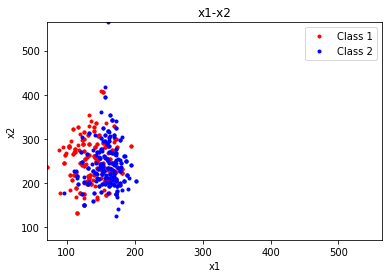

In [8]:
# Gaussian
# w_x1 = eigenvalues, v_x1 = eigenvectors
w_x1, v_x1 = np.linalg.eig(x1_ml_estimated_cov)
lambda_x1 = np.diag(w_x1)

# w_x2 = eigenvalues, v_x2 = eigenvectors
w_x2, v_x2 = np.linalg.eig(x2_ml_estimated_cov)
lambda_x2 = np.diag(w_x2)

# matrices of 200 points for the two classes X1 and X2

plot_2d_graph(x1_matrix, x2_matrix, 2, 6, 'x1', 'x2', 'x1-x2')
# len(x2_matrix1[2])

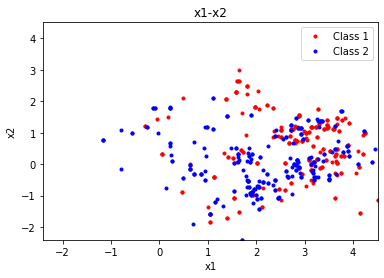

In [10]:
v1_matrix, v2_matrix, sigma_v1, sigma_v2, m_v1, m_v2 = simultaneousDiagonalization(x1_matrix, x2_matrix, x1_ml_estimated_cov, x2_ml_estimated_cov, x1_ml_estimated_mean, x2_ml_estimated_mean)
# v1_matrix1 = generatePointMatrix(v1_matrix, v_x1, lambda_x1, x1_ml_estimated_mean, x1_no_of_points)
# v2_matrix1 = generatePointMatrix(v2_matrix,v_x2, lambda_x2, x2_ml_estimated_mean, x2_no_of_points)

# v1_matrix = v1_matrix1
# v2_matrix = v2_matrix1
plot_2d_graph(v1_matrix, v2_matrix, 2, 6, 'x1', 'x2', 'x1-x2')

In [11]:
#@title CALCULATING ML MEAN AND COVARIANCE
x1_no_of_points = len(x1_matrix[0])
# get estimated mean and covariance using ML method
v1_ml_estimated_mean = mleMean(v1_matrix, x1_no_of_points)
# x1_ml_estimated_cov = estimate_cov_ml(x1_training_points, x1_ml_estimated_mean, no_of_points)
print('\nEstimated Mean1 using ML before Diagonalization:')
print(v1_ml_estimated_mean)
v1_ml_estimated_cov = mleCov(v1_matrix, v1_ml_estimated_mean, x1_no_of_points)
print('\nEstimated covariance1 using ML before Diagonalization:')
print(v1_ml_estimated_cov)
x2_no_of_points = len(x2_matrix[0])
v2_ml_estimated_mean = mleMean(v2_matrix, x2_no_of_points)
v2_ml_estimated_cov = mleCov(v2_matrix, v2_ml_estimated_mean, x2_no_of_points)
print('\nEstimated Mean2 using ML before Diagonalization:')
print(v2_ml_estimated_mean)
print('\nEstimated covariance2 using ML before Diagonalization:')
print(v2_ml_estimated_cov)


Estimated Mean1 using ML before Diagonalization:
[[0.85196124]
 [2.71804394]
 [4.19046835]
 [3.87657615]
 [4.85621484]
 [0.56669167]]

Estimated covariance1 using ML before Diagonalization:
[[ 1.00000000e+00  5.72100738e-15 -2.07772184e-14  4.94407361e-15
   1.42697070e-14 -4.57467491e-14]
 [ 5.72100738e-15  1.00000000e+00  2.58527941e-14  3.49676029e-14
  -2.07268412e-14 -7.15075160e-14]
 [-2.07772184e-14  2.58527941e-14  1.00000000e+00 -1.65496926e-14
   9.40608360e-15  3.11631139e-14]
 [ 4.94407361e-15  3.49676029e-14 -1.65496926e-14  1.00000000e+00
   2.45566407e-14 -3.38541570e-15]
 [ 1.42697070e-14 -2.07268412e-14  9.40608360e-15  2.45566407e-14
   1.00000000e+00  2.26942510e-14]
 [-4.57467491e-14 -7.15075160e-14  3.11631139e-14 -3.38541570e-15
   2.26942510e-14  1.00000000e+00]]

Estimated Mean2 using ML before Diagonalization:
[[1.11828899]
 [2.16489706]
 [4.00077125]
 [4.84299564]
 [5.19825486]
 [0.12060025]]

Estimated covariance2 using ML before Diagonalization:
[[ 1.543813

In [12]:
#@title BAYES DISCRIMINANT FUNCTIONS CALCULATION AND PLOTTING
def bayesDiscriminant(m1, m2, cov1, cov2, x1_points, x2_points, p1, p2, d1, d2, method):
  a = ((np.linalg.inv(cov2) - np.linalg.inv(cov1)) / 2)
  b = np.array(m1.transpose() @ np.linalg.inv(cov1) - m2.transpose() @ np.linalg.inv(cov2))
  c = (np.math.log(p1 / p2) + np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))
  # c= (np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))/2 + np.math.log(p1 / p2) + ( ( m2.transpose() @ np.linalg.inv(cov2) @ m1)-(m1.transpose() @ np.linalg.inv(cov1) @ m1))
  equation_points = []
  roots_1 = []
  roots_2 = []

  min_w = min(min(min(x1_points[d1 - 1]), min(x2_points[d1 - 1])),
              min(min(x1_points[d2 - 1]), min(x2_points[d2 - 1])))
  max_w = max(max(max(x1_points[d1 - 1]), max(x2_points[d1 - 1])),
              max(max(x1_points[d2 - 1]), max(x2_points[d2 - 1])))

  for x1 in np.arange(min_w - 1, max_w + 1, 1):
      equation_points.append(x1)
      x2_square_coefficient = a[d2 - 1][d2 - 1]
      x2_coefficient = (a[d1 - 1][d2 - 1] * x1) + (a[d2 - 1][d1 - 1] * x1) + b[0][d2 - 1]
      constant = a[d1 - 1][d1 - 1] * np.math.pow(x1, 2) + b[0][d1 - 1] * x1 + c

      poly_coefficients = [x2_square_coefficient, x2_coefficient, constant]
      roots = np.roots(poly_coefficients)
      roots_1.append(roots[0])
      roots_2.append(roots[1])

  # plot_2d_graph_with_line(x1_points, x2_points, d1, d2, str(d1), str(d2), method, equation_points_x2x3, roots_1_x2x3, roots_2_x2x3)
  plt.plot(x1_points[d1 - 1], x1_points[d2 - 1], 'r.', label="Class 1")
  plt.plot(x2_points[d1 - 1], x2_points[d2 - 1], 'b.', label="Class 2")
  plt.plot(equation_points, roots_2, 'g--', label="Dis.Fnc.")
  plt.plot(equation_points, roots_1, 'y--', label="Dis.Fnc.")
  plt.xlabel('x' + str(d1))
  plt.ylabel('x' + str(d2))

  plt.axis([min_w, max_w, min_w, max_w])
  plt.title('Dis. Fun. for ' + method + ' for x' + str(d1) + '-x' + str(d2))
  plt.legend(loc=2)
  plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


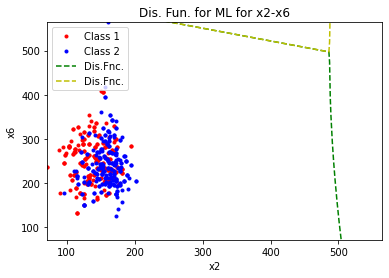

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


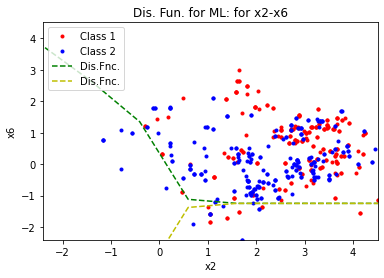

In [16]:
bayesDiscriminant(x1_ml_estimated_mean, x2_ml_estimated_mean, x1_ml_estimated_cov,
                                    x2_ml_estimated_cov, x1_matrix, x2_matrix, (len(x1_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) ), (len(x2_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) ), 2, 6, 'ML')
bayesDiscriminant(v1_ml_estimated_mean, v2_ml_estimated_mean, v1_ml_estimated_cov,
                                    v2_ml_estimated_cov, v1_matrix, np.array(v2_matrix), (len(x1_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) ), (len(x2_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) ), 2, 6, 'ML:')

In [ ]:
(len(x1_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) )

0.4765625